In [1]:
import csv
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42

In [2]:
static_csv_path = os.path.join(os.getcwd(), 'models/static_gesture/data/gesture.csv')
static_classifier_path = os.path.join(os.getcwd(), 'models/static_gesture/static_classifier.keras')
static_tflite_path = os.path.join(os.getcwd(), 'models/static_gesture/static_classifier.tflite')

In [3]:
NUM_CLASSES = 2

In [4]:
# X_lim represents 21 hand landmarks with X,Y coords (therefore x2) and one handedness column
X_lim = 1 + (21 * 2)
X_range = range(1, X_lim + 1)

X = np.loadtxt(static_csv_path, delimiter=',', dtype='float32', usecols=list(X_range))

y = np.loadtxt(static_csv_path, delimiter=',', dtype='float32', usecols=(0)).astype(np.int64)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((X_lim, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [7]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 43)                0         
                                                                 
 dense (Dense)               (None, 20)                880       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1112 (4.34 KB)
Trainable params: 1112 (4.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    static_classifier_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [9]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/4 [======>.......................] - ETA: 1s - loss: 0.7334 - accuracy: 0.5703
Epoch 1: saving model to C:\Users\Mickey Nine\PythonProjects\repo\py_projects\hand_tracking\models/static_gesture\static_classifier.keras
4/4 [==============================] - 1s 68ms/step - loss: 0.7576 - accuracy: 0.5644 - val_loss: 0.6463 - val_accuracy: 0.5734
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.7039 - accuracy: 0.5859
Epoch 2: saving model to C:\Users\Mickey Nine\PythonProjects\repo\py_projects\hand_tracking\models/static_gesture\static_classifier.keras
4/4 [==============================] - 0s 17ms/step - loss: 0.7098 - accuracy: 0.5714 - val_loss: 0.6073 - val_accuracy: 0.7203
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 0.6215 - accuracy: 0.6484
Epoch 3: saving model to C:\Users\Mickey Nine\PythonProjects\repo\py_projects\hand_tracking\models/static_gesture\static_classifier.keras
4/4 [==============================] - 0s 16ms/s

In [11]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 [==============================] - 0s 3ms/step - loss: 3.9429e-04 - accuracy: 1.0000


In [12]:
# Loading the saved model
model = tf.keras.models.load_model(static_classifier_path)

In [13]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 143ms/step
[8.5915026e-04 9.9914086e-01]
1


5/5 [==============================] - 0s 1ms/step


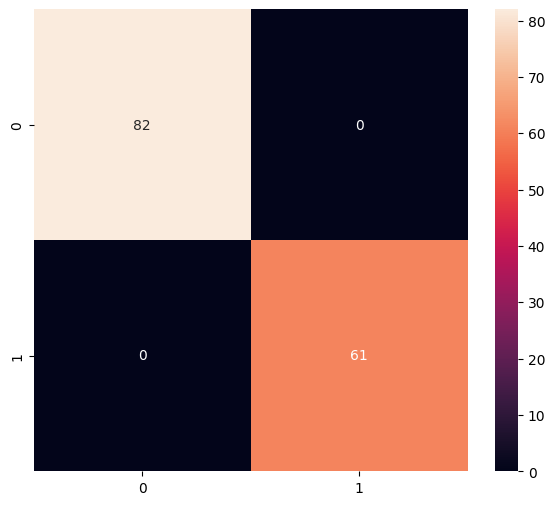

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        61

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143



In [14]:
def display_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

display_confusion_matrix(y_test, y_pred)

In [15]:
# Save as a model dedicated to inference
model.save(static_classifier_path)

In [16]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(static_tflite_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmpm5x_mhba\assets


INFO:tensorflow:Assets written to: C:\Users\MICKEY~1\AppData\Local\Temp\tmpm5x_mhba\assets


6536

In [17]:
interpreter = tf.lite.Interpreter(model_path=static_tflite_path)
interpreter.allocate_tensors()

In [18]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [20]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1. 0.]
0
